In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import Dataset
import numpy as np
from sklearn.metrics import f1_score
from torch.quantization import quantize_dynamic
import os
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d:\Anaconda\envs\AI_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
label_map = {'toxic':0, 'severe_toxic':1, 'obscene':2, 'threat':3, 'insult':4, 'identity_hate':5}

In [ ]:
test_dataset = Dataset.from_file(r"processed_dataset/subset_test/data-00000-of-00001.arrow")
model = AutoModelForSequenceClassification.from_pretrained(f"./models/BERT_Multi-Label_classification", num_labels=len(label_map.keys())).to(device)
tokenizer = AutoTokenizer.from_pretrained(f"./models/BERT_Multi-Label_classification")
# Create multi-label column
def create_multi_label(example):
    return {"labels": [np.float32(example[label]) for label in label_map.keys()]}

test_dataset = test_dataset.map(create_multi_label).remove_columns(list(label_map.keys()))
test_dataset[0]

### Save Quantized model

In [5]:
# Quantize the BERT model using dynamic quantization
quantized_model = quantize_dynamic(
    model,  # Base model
    {torch.nn.Linear},  # Layers to quantize
    dtype=torch.qint8  # Quantization data type
)

# Save the entire quantized model instead of just the state dictionary
quantized_model_path = "./models/BERT_Multi_Label_quantized_model/quantized_model_full.pt"
torch.save(quantized_model, quantized_model_path)
print(f"Quantized model saved to {quantized_model_path}")

Quantized model saved to ./models/BERT_Multi_Label_quantized_model/quantized_model_full.pt


### Load quantized model

In [ ]:
# Load the full quantized model
quantized_model = torch.load(quantized_model_path, map_location=device)
print("Quantized model loaded successfully.")


C:\Users\saran\AppData\Local\Temp\ipykernel_192\1218196588.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantized_model = torch.load(quantized_model_path, map_locatio

Quantized model loaded successfully.


### Get metrics

In [7]:
# Update the function to load the entire model for size comparison
def print_size_of_model(model, name):
    torch.save(model, "temp.p")  # Save the entire model
    size_mb = os.path.getsize("temp.p") / 1e6
    print(f"{name} Size (MB): {size_mb:.2f}")
    os.remove("temp.p")

# Print sizes of the original and quantized models
print_size_of_model(model, "Original Model")
print_size_of_model(quantized_model, "Quantized Model")

Original Model Size (MB): 438.06
Quantized Model Size (MB): 181.50
Quantized Model Size (MB): 181.50


In [ ]:
# Compare inference time and F1 score for base and quantized models
def evaluate_model(model, tokenizer):
    start_time = time.time()
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=device,
        top_k=None
    )
    results = classifier(test_dataset['comment_text'], max_length=128, padding="max_length", truncation=True)
    end_time = time.time()

    # Process results to binary predictions
    cleaned_results = [
        [1 if score["score"] > 0.5 else 0 for score in result]
        for result in results
    ]

    # Compute F1 score
    f1 = f1_score(test_dataset['labels'], cleaned_results, average='micro')
    inference_time = end_time - start_time

    return f1, inference_time

# Evaluate base model
base_f1, base_time = evaluate_model(model, tokenizer)
print(f"Base Model - F1 Score: {base_f1:.4f}, Inference Time: {base_time:.2f} seconds")

# Evaluate quantized model
quantized_f1, quantized_time = evaluate_model(quantized_model, tokenizer)
print(f"Quantized Model - F1 Score: {quantized_f1:.4f}, Inference Time: {quantized_time:.2f} seconds")

Device set to use cpu
Device set to use cpu
Device set to use cpu


Base Model - F1 Score: 0.5901, Inference Time: 98.76 seconds
Quantized Model - F1 Score: 0.5940, Inference Time: 57.73 seconds
Quantized Model - F1 Score: 0.5940, Inference Time: 57.73 seconds


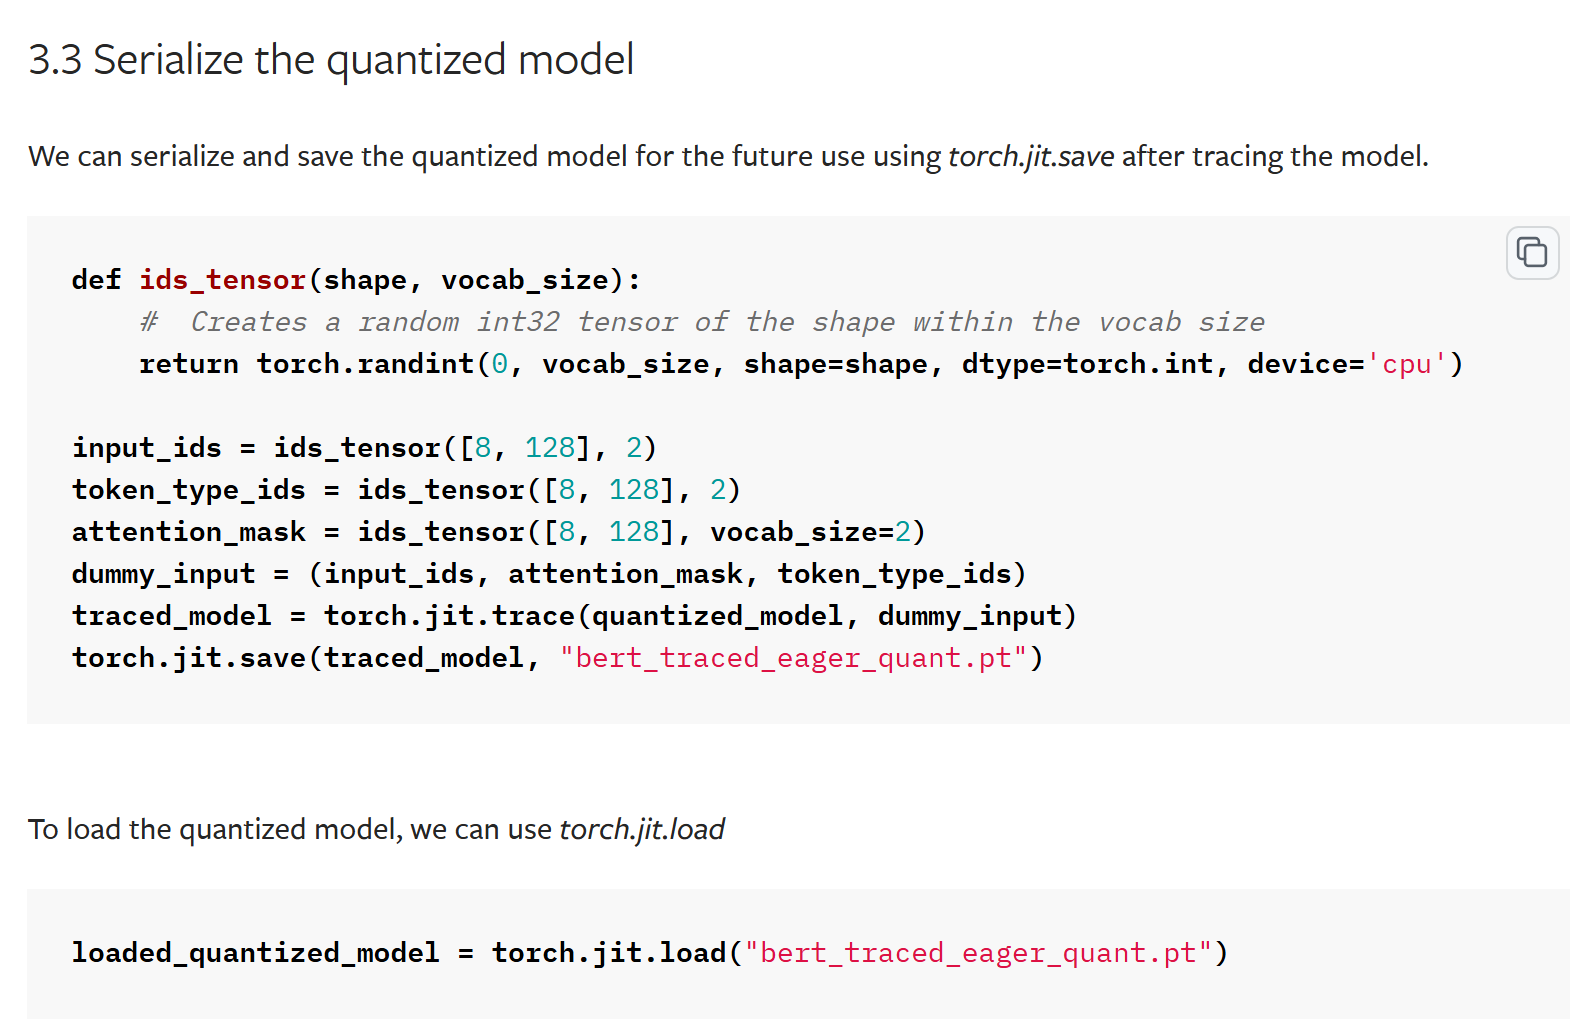